In [1484]:
#pip install pyspellchecker
#pip install langdetect
#pip install wordninja
#pip install googletrans==4.0.0-rc1


# Download stopwords
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize


In [4]:
df = pd.read_csv('train.csv')
df.head()

,text,sentiment
0,I am taking Avadart and thought I would try Pr...,negative
1,It was with much amusement that I read Nicko M...,negative
2,Cate Blanchett rocked these stunning gold stat...,positive
3,Manturov: Russia and Iran may begin the paymen...,neutral
4,We bought some vintage jars at a thrift store ...,neutral


In [5]:
df.shape

(8000, 2)

In [6]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [7]:
print('Original size of vocabulary or unique tokens: ',len(set(word_tokenize(' '.join(df['text'])))))

Original size of vocabulary or unique tokens:  32505


\
Check for __non english__ text.

In [111]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df['is_english'] = df['text'].apply(is_english)
non_english_texts = df[~df['is_english']]
non_english_texts.head(3)

,text,sentiment,is_english
56,Do n't say you were n't warned .,negative,False
61,Para hacer corta lo que deber├φa ser una larga...,negative,False
83,voila un bout de temp qu'on n'avait pas vu des...,positive,False


In [112]:
non_english_texts.shape

(56, 3)

In [15]:
df.text[61]

'Para hacer corta lo que deber├φa ser una larga rese├▒a, este es un libro introductorio a las ense├▒anzas toltecas, y un pobre intento en el tema, no acabo de entender como DonMiguel endorsa estos libros, esta supuesta mujer "Nagual" muestra a lo largo del libro que esta llenita de su ego, veneno en contra de los hombre y que alguna relaci├│n que tuvoEn el pasado, nunca la sano completamente.Si esta interesado en aprender el camino tolteca, vaya a las fuentes, Carlos Castaneda, Miguel Ruiz y Theun Mares, no pierda su tiempo y dinero con estos farsantes.PSEspec├φficamente, de la versi├│n en espa├▒ol, que traducci├│n tan horrible.'

### Preprocessing
In this section we will preprocess the text in order to prepare the data for EDA and ML
1. __remove URLs__
2. __remove tags__ @someone and split __hashtags__ with combined words #SummerGreece -> Summer Greece instead of SummerGreece.  
3. __convert patterns__ that denote to facial expressions to text e.g __:)__ denotes to __happy face__.
4. __convert Slangs to text__ e.g lol-> laughing out loud, omg -> oh my god.
5. __basic text preprocessing__ such as lowercase, remove punctuations and extra spaces.
6. __translate non english text.__
7. __apply lemmatization or porter stem__

__(!!!!!) It is essential to note that GridSearch was applied on steps 2, 3, 4, 7 on a different notebook with final results:__
 - __Step 2: keep_hashtags = True__
 - __Step 3: replace_patterns = True__
 - __Step 4: replace_slangs = True__
 - __Step 7: PorterStem__ over Lemmatizer, both performed better without filtering stopwords.


### Note 
Further preproccessing will be applied on EDA section.

__Step 1.__ remove URLs

In [12]:
def remove_URL_HTML(text):
    # Remove URLs
    text = re.sub(r"http.\S+", '', text)
    text = re.sub(r"www.\S+", '', text)
    text = re.sub(r"pic.twitter.com\S+", '', text)
    # Remove HTML/XML tags
    if re.search(r'<.*?>', text):  
        text = BeautifulSoup(text, "html.parser").get_text()  
        
    return text

df['cleaned_text'] = df['text'].apply(remove_URL_HTML)

\
__Step 2.__ remove all the tagged users __@someone__ and split the hashtags __#summerholidays__.

In [14]:
import wordninja

def remove_tags_and_split_hashtags(text, keep_hashtags=True):
    # Remove @USER (e.g., @user1, @someone)
    text = re.sub(r'@[\w]+', '', text)

    if keep_hashtags:
        # Find all hashtags (e.g., #something)
        hashtags = re.findall(r'#\w+', text)
        
        # Replace hashtags with their split version
        for hashtag in hashtags:
            # Remove the '#' and split the word into components
            split_words = ' '.join(wordninja.split(hashtag[1:]))
            text = text.replace(hashtag, split_words)
    else:
        # Remove hashtags completely
        text = re.sub(r'#\w+', '', text)
    
    return text

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_tags_and_split_hashtags(x, keep_hashtags=True))

In [15]:
hashtag_pattern = r'#\w+'
df_hashtags = df[df['text'].str.contains(hashtag_pattern, regex=True, case=False, na=False)]

In [17]:
print('original_text: ', df_hashtags.text.iloc[0])
print('cleaned_text: ', df_hashtags.cleaned_text.iloc[0])

original_text:  Manturov: Russia and Iran may begin the payments in national currencies https://t.co/HBVOA6xntY #news #Russia
cleaned_text:  Manturov: Russia and Iran may begin the payments in national currencies  news Russia


\
__Step 3.__ check for text patterns that denote to __emojis / facial expressions__ e.g:
- __:)__ = smiley face
- __:(__ = sad face 

In [23]:
happy_pattern = r'(:\))'
df_happy = df[df['cleaned_text'].str.contains(happy_pattern, regex=True, case=False, na=False)]
sad_pattern = r'(:\()'
df_sad = df[df['cleaned_text'].str.contains(sad_pattern, regex=True, case=False, na=False)]

In [25]:
print('Happy face :)  text:', df_happy.cleaned_text.iloc[0])
print('Sad face :(    text:', df_sad.cleaned_text.iloc[0])

Happy face :)  text: Alexandra de Curtis, Rome: The Satchel - Grande &amp; Piccola :) brighten up your Friday with these beautiful bags! 
Sad face :(    text: tomorrow i'm gonna lock myself in my room and not be on social media all day bc I don't want to see any posts about Ed Sheeran concert :(((


Custom dictionary that converts text patterns that denote face expressions into words, more info on [Wiki](https://en.wikipedia.org/wiki/List_of_emoticons)

In [28]:
emoji_dict = {
    r':-\)': ' happy face ',
    r':\)': ' happy face ',
    r':D': ' laugh face ',
    r':-\(': ' sad face ',
    r':\(': ' sad face ',
    r':O': ' surprised face ',
    r';-\)': ' wink face ',
    r';\)': ' wink face ',
    r':P': ' playful face ',
    r':-\?': ' undecided face ',
    r':/': ' undecided face ',
    r"\b't\b": " not" # I added this to keep all the verbs with not e.g can't -> cannot
}  

In [30]:
def replace_patterns_with_meaning(text, emoji_dict, replace=True):
    if replace:
        for emoji, meaning in emoji_dict.items():
            text = re.sub(emoji, meaning, text)
    return text

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: replace_patterns_with_meaning(x, emoji_dict))

In [31]:
replace_patterns_with_meaning('Merry Christmas :)',emoji_dict)

'Merry Christmas  happy face '

\
__Step 4.__ check for __Slangs__ such as lol or omg. I also used a dictionary __abbreviations__ from [Kaggle](https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/notebook)

In [35]:
filtered_df = df[df['cleaned_text'].str.contains(r'\bomg\b|\blol\b', case=False, na=False)]
filtered_df.text.head(2)

314    Lol desperate AF! "@UFCONFOX: Dana White confi...
707    @CaraLTaylor as promiscuous reader (lol) you m...
Name: text, dtype: object

In [37]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "af" : "as fuck",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",   
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "c'mon" : "come on",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [39]:
def replace_abbreviations(text, abbreviations, replace=True):
    if replace:
        words = text.split()
        replaced_words = [abbreviations.get(word.lower(), word) for word in words]  # .lower() to make case-insensitive
    return " ".join(replaced_words)

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: replace_abbreviations(x, abbreviations))

In [41]:
replace_abbreviations('hello zzz', abbreviations)

'hello sleeping bored and tired'

__Step 5.__ basic text preprocessing.

In [44]:
# Preprocess function to clean text
def preprocess_text(text):

    # Convert text to lowercase, remove punctuation and extra spaces
    text = text.lower()  
    text = re.sub(r'\d+', ' ', text) 
  #  text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'[^!\?\'\w\s]', '', text)  # Keep '!', '?'??????????????? to capture more expressions??
    return text

df['cleaned_text'] = df['cleaned_text'].apply(preprocess_text)

In [45]:
df.text[15]

'@FieldGulls @ScottEnyeart Dana White said the Bellagio had to freeze payouts for an hour  Sat because they lost all the money in their safe.'

In [48]:
df.cleaned_text[15]

'dana white said the bellagio had to freeze payouts for an hour sat because they lost all the money in their safe'

__Step 6.__ transalte non english tweets.

In [51]:
from googletrans import Translator
from langdetect import detect

translator = Translator()

# Function to detect language and translate to English
def translate_to_english(text):
    try:
        language = detect(text)
        if language != 'en':
            translated_text = translator.translate(text, src=language, dest='en').text
            return translated_text
        else:
            return text 
    except Exception as e:
        print(f"Error: {e}")
        #return original text in case of any error
        return text

# Apply the translate_to_english function to the text column
df['cleaned_text'] = df['cleaned_text'].apply(translate_to_english)

In [154]:
df.text[61]

'Para hacer corta lo que deber├φa ser una larga rese├▒a, este es un libro introductorio a las ense├▒anzas toltecas, y un pobre intento en el tema, no acabo de entender como DonMiguel endorsa estos libros, esta supuesta mujer "Nagual" muestra a lo largo del libro que esta llenita de su ego, veneno en contra de los hombre y que alguna relaci├│n que tuvoEn el pasado, nunca la sano completamente.Si esta interesado en aprender el camino tolteca, vaya a las fuentes, Carlos Castaneda, Miguel Ruiz y Theun Mares, no pierda su tiempo y dinero con estos farsantes.PSEspec├φficamente, de la versi├│n en espa├▒ol, que traducci├│n tan horrible.'

In [155]:
df.cleaned_text[61]

'To cut what should be a long review this is an introductory book to the toltec teaching and a poor attempt in the subject I did not just understand how Donmiguel Endorsa these books This supposed Nagual woman shows throughout the book that is filled with herPoison ego against the man and that some relationship that the health never had the healthSpanish that translates so horrible'

__Step 7.__ perform lemmatization or stemming.

In [56]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
#Words to exclude from stopwords
words_to_exclude = {"not"}  # Add the words you want to exclude
stop_words = stop_words.difference(words_to_exclude)  # Remove specific words from stopwords


def stopwords_lemma(text, stopwords=False):

    text = text.lower()
    lemmatizer = WordNetLemmatizer()
    # Tokenize text and apply POS tagging
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    lemmatized_text = []

    for word, tag in tagged_words:
        # Convert POS tags to WordNet POS format for lemmatization
        if tag.startswith('VB'):  # Verb
            lemma = lemmatizer.lemmatize(word, pos='v')
        elif tag.startswith('NN'):  # Noun
            lemma = lemmatizer.lemmatize(word, pos='n')
        elif tag.startswith('JJ'):  # Adjective
            lemma = lemmatizer.lemmatize(word, pos='a')
        elif tag.startswith('RB'):  # Adverb
            lemma = lemmatizer.lemmatize(word, pos='r')
        else:
            lemma = lemmatizer.lemmatize(word)  # Default case

        # Include or exclude stopwords based on the parameter
        if stopwords and word.lower() in stop_words:
            continue

        lemmatized_text.append(lemma)

    return " ".join(lemmatized_text)

# Apply the function to the 'cleaned_text' column
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: stopwords_lemma(x, stopwords=False))

In [161]:
df.text[0]

'I am taking Avadart and thought I would try Prostalex, because I am still having trouble going at night. I took theProstalex for 30 days and noticed no improvement.'

In [168]:
df.cleaned_text[0]

'i be take avadart and thought i would try prostalex because i be still have trouble go at night i take theprostalex for day and noticed no improvement'

In [52]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag

stop_words = set(stopwords.words('english'))
words_to_exclude = {"not", "no"}  # words to exclude
stop_words = stop_words.difference(words_to_exclude) 

# Function to clean and stem text
def stopwords_and_stem(text, stopwords=False):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)  
    if stopwords:
        stemmed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words]
    else:
        stemmed_tokens = [stemmer.stem(word.lower()) for word in tokens]
    return " ".join(stemmed_tokens)

# Apply the function to your dataframe
df['cleaned_text'] = df['cleaned_text'].apply(stopwords_and_stem)

In [66]:
df.text[0]

'I am taking Avadart and thought I would try Prostalex, because I am still having trouble going at night. I took theProstalex for 30 days and noticed no improvement.'

In [67]:
df.cleaned_text[0]

'i am take avadart and thought i would tri prostalex becaus i am still have troubl go at night i took theprostalex for day and notic no improv'

## Exploratory Data Analysis
In this section, we will see some useful plots, apply further preprocessing based on our findings, and attempt to determine outliers usin  DBSCAN clustering.


#### 1. Frequency of classes.

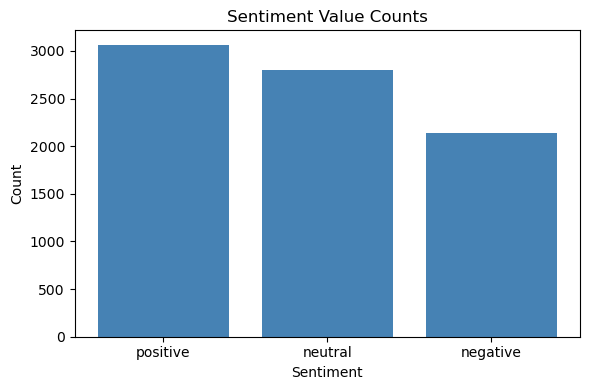

In [59]:
sentiment_counts = df.sentiment.value_counts()

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='steelblue')
plt.title('Sentiment Value Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [61]:
# % 
round(df.sentiment.value_counts(normalize=True)* 100)

sentiment
positive    38.0
neutral     35.0
negative    27.0
Name: proportion, dtype: float64

#### 2. Distribution and boxplot of number of tokens for each text / tweet.

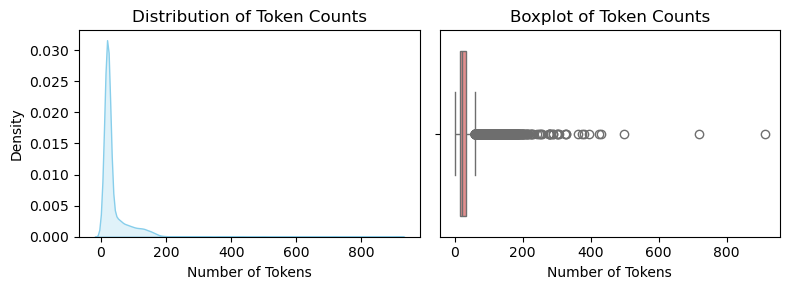

In [64]:
df['num_tokens'] = df.cleaned_text.apply(lambda x : len(word_tokenize(x)))

plt.figure(figsize=(8,3))

# distribution 
plt.subplot(1, 2, 1)  
sns.kdeplot(df['num_tokens'], color='skyblue', shade=True)
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')

# boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['num_tokens'], color='lightcoral')
plt.title('Boxplot of Token Counts')
plt.xlabel('Number of Tokens')
plt.tight_layout()
plt.show()

Let's also check for each sentiment 

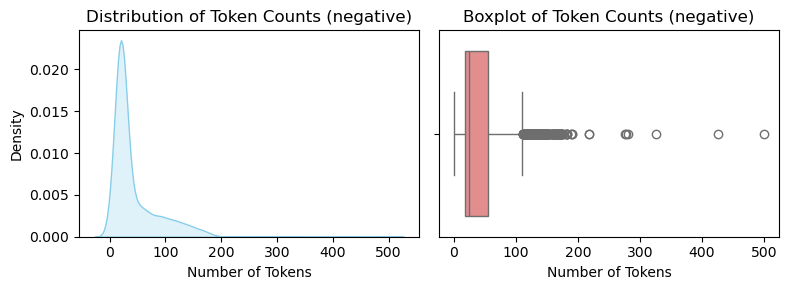

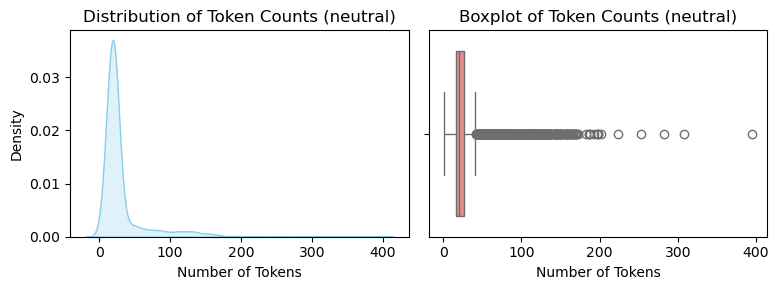

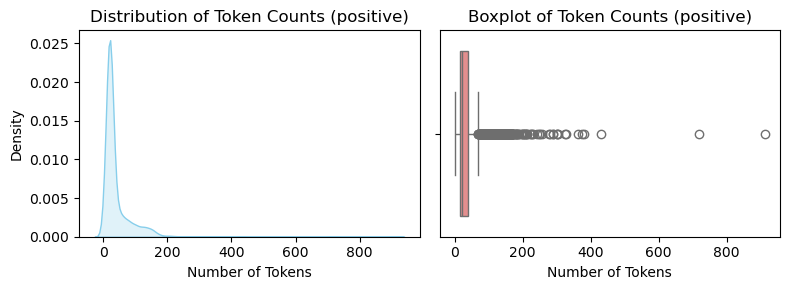

In [67]:
sentiments = ['negative', 'neutral', 'positive']  

for sentiment in sentiments:
    sentiment_df = df[df['sentiment'] == sentiment]
    
    plt.figure(figsize=(8, 3))
    
    # Distribution
    plt.subplot(1, 2, 1)
    sns.kdeplot(sentiment_df['num_tokens'], color='skyblue', shade=True)
    plt.title(f'Distribution of Token Counts ({sentiment})')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Density')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=sentiment_df['num_tokens'], color='lightcoral')
    plt.title(f'Boxplot of Token Counts ({sentiment})')
    plt.xlabel('Number of Tokens')
    
    plt.tight_layout()
    plt.show()


In [91]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_tokens,8000.0,37.252125,41.703746,1.0,17.0,22.0,34.0,911.0


In [71]:
len(df[df['num_tokens'] > 100])

711

In [73]:
df[df['num_tokens'] < 3][:5]

,text,sentiment,cleaned_text,num_tokens
1001,Psychologically revealing .,positive,psychologically reveal,2
1270,Highly engaging .,positive,highly engage,2
1506,A. . .,neutral,the,1
2142,Rewarding .,positive,reward,1
2564,I like it .,positive,likey,1


__1506 is an outlier__

#### 3. Most frequent words with Negative, Neutral, Positve sentiment and on the entire data.

In [77]:
def remove_short_words(text):
    words = text.split()  
    filtered_words = [word for word in words if len(word) >= 2]  
    return ' '.join(filtered_words)  

df['cleaned_text'] = df['cleaned_text'].apply(remove_short_words)

In [79]:
stop_words = set(stopwords.words('english'))
df['eda_tokens'] = df['cleaned_text']\
                   .apply(lambda text: [word for word in word_tokenize(text.lower()) if word not in stop_words])

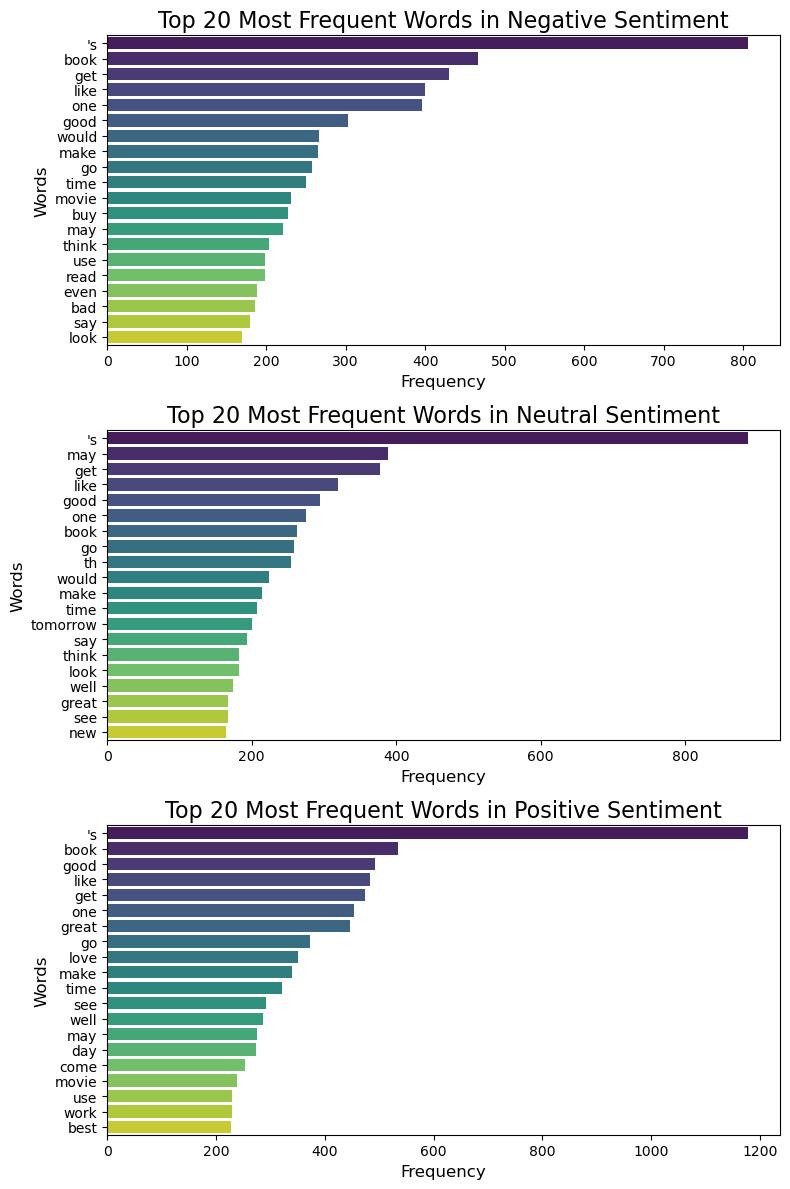

In [80]:
sentiments = ['negative', 'neutral', 'positive']

plt.figure(figsize=(8, 12))
# Loop over each sentiment category and plot the top 20 words
for idx, sentiment in enumerate(sentiments, 1):
    # Filter the DataFrame for each sentiment and get the top 20 words
    top_20_words = df[df.sentiment == sentiment].explode('eda_tokens').eda_tokens.value_counts(ascending=False)[:20]
    
    # Create a subplot for each sentiment category
    plt.subplot(3, 1, idx)
    sns.barplot(x=top_20_words.values, y=top_20_words.index, palette="viridis")
    plt.title(f'Top 20 Most Frequent Words in {sentiment.capitalize()} Sentiment', fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
plt.tight_layout()
plt.show()

In [83]:
neutral_th_df = df[(df['sentiment'] == 'neutral') & 
                   (df['eda_tokens'].apply(lambda tokens: 'th' in tokens))]

neutral_th_df.head(3)

,text,sentiment,cleaned_text,num_tokens,eda_tokens
53,we pumping inside twilight on Dec 19th UGLY SW...,neutral,we pump inside twilight on dec th ugly sweater...,16,"[pump, inside, twilight, dec, th, ugly, sweate..."
54,"As the 4th largest military in the world, Saud...",neutral,the th large military in the world saudi arabi...,22,"[th, large, military, world, saudi, arabia, ne..."
197,briana's mum said that briana is 34 weeks preg...,neutral,briana 's mum say that briana be week pregnant...,23,"[briana, 's, mum, say, briana, week, pregnant,..."


Check why the word __th__ has so many occurancies on text with __neutral__ sentiment and determine whether to keep it or not.

In [82]:
print(df.text[53])
print(df.text[54])
print(df.text[197])

we pumping inside twilight on Dec 19th UGLY SWEATER FETE'R with @SKFTHECHAMP @Badnewz_JUK @BassLinetheMC @DJSOCASWEETNESS Get Mad Now..
As the 4th largest military in the world, Saudi Arabia needs to step up Big Time to dissolve ISIS #GOPDebate #LA06 https://t.co/ENMKsR2AqO
briana's mum said that briana is 34 weeks pregnant which falls around the 30th of april and louis is in london by then


#### 4. World Cloud for Negative, Neutral, Positive Sentiment and for the Entire Dataset

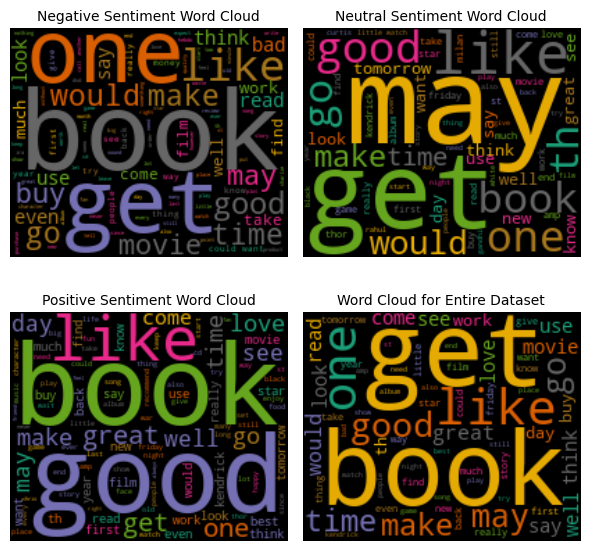

In [85]:
from textwrap import wrap

def generate_wordcloud(data, title, ax):
    wc = WordCloud(width=200, height=165, max_words=150, colormap="Dark2").generate_from_frequencies(data)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title('\n'.join(wrap(title, 60)), fontsize=10) 

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

# Create word frequency for negative sentiment
negative_tokens = df[df['sentiment'] == 'negative']['eda_tokens'].explode()
negative_tokens = negative_tokens[negative_tokens.apply(lambda x: isinstance(x, str))]  # Filter non-string tokens bcs some rows where None
negative_text = ' '.join(negative_tokens)                                               # bcs of the stopwords filtering
negative_freq = pd.Series(negative_text.split()).value_counts()                         # e.g text = A!!!! becomes None 

# Create word frequency for neutral sentiment
neutral_tokens = df[df['sentiment'] == 'neutral']['eda_tokens'].explode()
neutral_tokens = neutral_tokens[neutral_tokens.apply(lambda x: isinstance(x, str))]  
neutral_text = ' '.join(neutral_tokens)
neutral_freq = pd.Series(neutral_text.split()).value_counts()

# Create word frequency for positive sentiment
positive_tokens = df[df['sentiment'] == 'positive']['eda_tokens'].explode()
positive_tokens = positive_tokens[positive_tokens.apply(lambda x: isinstance(x, str))] 
positive_text = ' '.join(positive_tokens)
positive_freq = pd.Series(positive_text.split()).value_counts()

# Create word frequency for the entire dataset
all_tokens = df['eda_tokens'].explode()
all_tokens = all_tokens[all_tokens.apply(lambda x: isinstance(x, str))]  
all_text = ' '.join(all_tokens)
all_freq = pd.Series(all_text.split()).value_counts()


generate_wordcloud(negative_freq, "Negative Sentiment Word Cloud", axes[0, 0])
generate_wordcloud(neutral_freq, "Neutral Sentiment Word Cloud", axes[0, 1])
generate_wordcloud(positive_freq, "Positive Sentiment Word Cloud", axes[1, 0])
generate_wordcloud(all_freq, "Word Cloud for Entire Dataset", axes[1, 1])

plt.tight_layout()
plt.show()

#### Apply more preprocessing.

In [53]:
def remove_short_words(text):
    
    words = text.split()  
    filtered_words = [word for word in words if len(word) >= 2]  
    return ' '.join(filtered_words)  

In [57]:
len(set(word_tokenize(' '.join(df['cleaned_text']))))

17931

In [59]:
#after removing words with len() = 1
df['cleaned_text'] = df['cleaned_text'].apply(remove_short_words)
len(set(word_tokenize(' '.join(df['cleaned_text']))))

17901

In [61]:
def preprocess_text_with_token_limit(text, token_limit=200, token_cut=100):

    tokens = word_tokenize(text)
    if len(tokens) > token_limit:
        tokens = tokens[:token_cut] + tokens[-token_cut:]
    
    return ' '.join(tokens)

df['cleaned_text'] = df['cleaned_text'].apply(preprocess_text_with_token_limit)

In [62]:
# before preprocessing unique words (vocabulary)
len(set(word_tokenize(' '.join(df['text']))))

32505

In [65]:
# final unique words
len(set(word_tokenize(' '.join(df['cleaned_text']))))

17775

### Findings
1. The classes are imbalanced, __positive=38%__, __neutral= 35%__, __negative= 27%__ (this might influence the performance of our classifiers).
2. There many __outliers__, 720 out of the 8000 data points have more than 100 tokens 50% of the population has 22 while 
75 has 	3 tokens.
3. There are many common words bettween the different types of sentiments, espacially bettween neutral and positive texts.
4. The chance of __ending up__ with an __empty text__ is likely, due to the preprocessing steps or words that are out of the vocabulary (known words for our data mining algorithms that we will apply.
5. The original __vocabulary__ (unique tokens) was __32505__, which became __17775__ after preprocessing.
6. We applied __2 more preprocessing steps__, limit each text to 200 tokens (with the assumption that the majority of the information on a text is at start and at the end for each text) and filter out words with <2 length to remove extra noise.00


#### Clustering
Let's also try to apply __DBSCAN clustering__ to see whether we can effectively identify some outliers.

As observed in Plot 2, 75% of the texts contain 34 tokens or less. Therefore, we will truncate or pad the texts to 50 tokens. This is a crucial step, as clustering requires each data point to have the same number of dimensions.

Subsequently, we will use GloVe embeddings, where each word is represented in a 50-dimensional space. The final representation of each text will be the mean of the embeddings of all the tokens in the text. This implies that our total features will be 50.

If time permits, I will also experiment with transforming each text using either TF-IDF or CountVectorizer after determing that best performing classification model.

In [202]:
df['cleaned_text2'] = df['cleaned_text'].apply(lambda x : preprocess_text_with_token_limit(x, token_limit=50, token_cut=25))

In [70]:
def load_glove_embeddings(file_path, dimension=50):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_path = 'glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings(glove_path, dimension=50)
len(glove_embeddings)

400000

In [71]:
# Convert text to vector using GloVe embeddings by averaging word vectors
def text_to_glove_vector(text, embeddings, dimension=50):
    tokens = preprocess_text(text)
    word_vectors = [embeddings[word] for word in tokens if word in embeddings]
    if not word_vectors:  # If no words match, return a zero vector
        return np.zeros(dimension)
    return np.mean(word_vectors, axis=0)

# Convert all texts in the dataframe to GloVe vectors
X_glove = np.array([text_to_glove_vector(text, glove_embeddings) for text in df['cleaned_text2']])

print('Shape of GloVe vectorized data:', X_glove.shape)

Shape of GloVe vectorized data: (8000, 50)


In [72]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=3, metric='euclidean')  #eps=1 , min_samples= 3
predict = dbscan.fit_predict(X_glove)

                                    
I used a small number of `eps` and `min_samples` to retrieve DBSCAN's outliers with higher confidence.

In [77]:
# retrieve the number of different clsuters
np.unique(predict)

array([-1,  0], dtype=int64)

__Note:__ clusters with `-1 label` are always the __outliers__.

In [80]:
len(np.where(predict == -1)[0])

59

In [82]:
np.where(predict == -1)[0]

array([  52,  130,  341,  501,  814, 1001, 1024, 1031, 1270, 1506, 1642,
       1733, 2142, 2334, 2441, 2564, 2641, 2717, 3107, 3130, 3161, 3433,
       3617, 3706, 3917, 4059, 4442, 4479, 4493, 4742, 4933, 4936, 5009,
       5028, 5379, 5673, 5744, 5769, 5773, 6026, 6154, 6176, 6187, 6327,
       6379, 6413, 6454, 6479, 6486, 6511, 6562, 6580, 6752, 7367, 7491,
       7682, 7687, 7769, 7792], dtype=int64)

In [84]:
df.iloc[np.where(predict == -1)[0]]

,text,sentiment,cleaned_text,cleaned_text2
52,A fifty car pileup of cliches .,negative,fifti car pileup of clich,fifti car pileup of clich
130,One lousy movie .,negative,one lousi movi,one lousi movi
341,Moving and vibrant .,positive,move and vibrant,move and vibrant
501,Great dragons !,positive,great dragon,great dragon
814,Sonia Gandhi khan aur Rahul Gandhi khan. Dono...,positive,sonia gandhi khan khan gandhi khan kono kan kh...,sonia gandhi khan khan gandhi khan kono kan kh...
1001,Psychologically revealing .,positive,psycholog reveal,psycholog reveal
1024,Is today Star Wars day or is tomorrow Star War...,neutral,is today star war day or is tomorrow star war day,is today star war day or is tomorrow star war day
1031,"... very funny , very enjoyable ...",positive,veri funni veri enjoy,veri funni veri enjoy
1270,Highly engaging .,positive,highli engag,highli engag
1506,A. . .,neutral,the,the


As we see some of the predictions are true outliers, but the majority of them are not. \
Also, we observe that some of the text have __wrong sentiment classifications.__

In [87]:
# wrong sentiment
print(df.text.iloc[2717])
df.sentiment.iloc[2717]

Far away .


'neutral'

In [89]:
# wrong sentiment
print(df.text.iloc[3917])
df.sentiment.iloc[3917]

Ah , what the hell .


'neutral'

In [91]:
#wrong setniment
print(df.text.iloc[5744])  #translates to: what a surpsise!
df.sentiment.iloc[5744] 

Quelle surprise !


'neutral'

In [93]:
#wrong setniment
print(df.text.iloc[7769]) 
df.sentiment.iloc[7769] 

In a word : No. .


'neutral'

In [95]:
df.iloc[np.where(predict == -1)[0]].sentiment.value_counts(normalize=True)

sentiment
positive    0.389831
negative    0.338983
neutral     0.271186
Name: proportion, dtype: float64

Let's also use __PCA__, to reduce the dimensions to 2 in order to visualize the clusters. \
The following code / plot are from [here](https://vitalflux.com/pca-explained-variance-concept-python-example/).

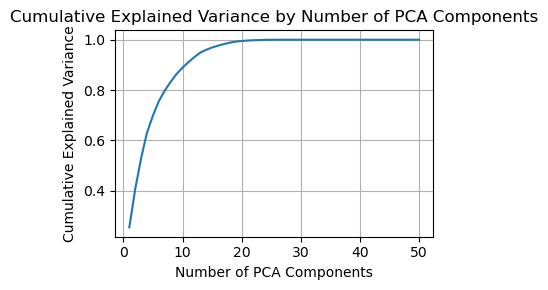

In [98]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(X_glove)

# Calculate the explained variance ratio (how much information each component explains)
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance (how much information is retained with more components)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance for each component
plt.figure(figsize=(4, 3))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
explained_variance_ratio[:2]

array([0.25388712, 0.1523383 ], dtype=float32)

In [102]:
print('Cumulative Explained Variance for the first two components:', cumulative_explained_variance[1])

Cumulative Explained Variance for the first two components: 0.4062254


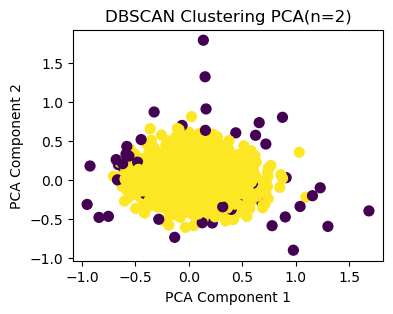

In [104]:
# Reduce the dimensionality to 2D for visualization (using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_glove)

# Visualize the clusters in 2D
plt.figure(figsize=(4, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict, cmap='viridis', marker='o', s=50)
plt.title('DBSCAN Clustering PCA(n=2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

__Note:__ I came here after finishing my exercise to determine whether keeping or not these data points will enhance the LinearSVC, the \
with classifier with the best performance.

In [123]:
tfidf = TfidfVectorizer(max_df=0.45, min_df=1, ngram_range=(1, 2), sublinear_tf=True)


X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment']

# LinearSVC with 10-fold cross-validation
linear_svc = LinearSVC()

# 1. Cross-validation on the full dataset
cv_scores = cross_val_score(linear_svc, X_tfidf, y, 
                            cv=StratifiedKFold(n_splits=10, shuffle=True), 
                            scoring='accuracy')

print('Avg cv accuracy:', (cv_scores.mean()))

Avg cv accuracy: 0.5948749999999999


In [124]:
# Filter potential outliers
outliers = df.iloc[np.where(predict == -1)[0]]
filtered_df = df.iloc[np.where(predict != -1)[0]]

In [125]:
X_filtered_tfidf = tfidf.transform(filtered_df['cleaned_text'])
y_filtered = filtered_df['sentiment']

# Cross-validation on the filtered dataset (excluding potential outliers)
cv_scores_filtered = cross_val_score(linear_svc, X_filtered_tfidf, y_filtered, 
                                     cv=StratifiedKFold(n_splits=10, shuffle=True), 
                                     scoring='accuracy')

print('Avg cv accuracy after removing outliers:', (cv_scores_filtered.mean()))

Avg cv accuracy after removing outliers: 0.5970239057079036


#### Similar approach using Decomposition

In [1684]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['cleaned_text2'])
y = df['sentiment']

In [1686]:
# Retrieve the number features from the TfidfVectorizer
len(tfidf.get_feature_names_out())

14969

In [214]:
# Apply TruncatedSVD instead of PCA bcs i get an error for the tfi-idf
svd = TruncatedSVD(n_components=1000) 
X_reduced = svd.fit_transform(X_tfidf)

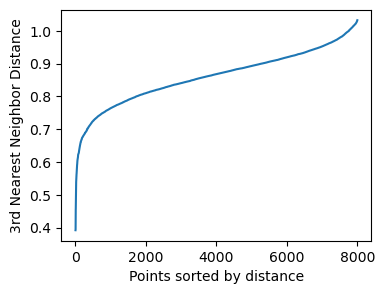

In [2680]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=25).fit(X_reduced)
distances, indices = neighbors.kneighbors(X_reduced)
distances = np.sort(distances[:, -1]) 

plt.figure(figsize=(4, 3))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("3rd Nearest Neighbor Distance")
plt.show()

In [2736]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.72, min_samples=25, metric='cosine')  
predict = dbscan.fit_predict(X_reduced)

In [2738]:
np.unique(predict)

array([-1,  0], dtype=int64)

In [2740]:
len(np.where(predict == -1)[0])

1819

In [2742]:
len(np.where(predict == 0)[0])

6181

In [2744]:
df.iloc[np.where(predict == -1)[0]]

,text,sentiment,cleaned_text,cleaned_text2
4,We bought some vintage jars at a thrift store ...,neutral,we bought some vintag jar at thrift store and ...,we bought some vintag jar at thrift store and ...
13,"@mynamesnotmilan @maarebear ""oh Milan just tex...",negative,oh milan just text me ohhh aw no she can not c...,oh milan just text me ohhh aw no she can not c...
23,This record is awful. Why these other reviewer...,negative,thi record is aw whi these other review compar...,thi record is aw whi these other review compar...
32,Kapur fails to give his audience a single char...,negative,kapur fail to give hi audienc singl charact wo...,kapur fail to give hi audienc singl charact wo...
40,I met up with a few ladies here for drinks a f...,neutral,met up with few ladi here for drink few week b...,met up with few ladi here for drink few week b...
...,...,...,...,...
7982,It 's secondary to American Psycho but still h...,positive,it 's secondari to american psycho but still h...,it 's secondari to american psycho but still h...
7986,"BUENOS AIRES, Dec 11 (Reuters) - Argentina's n...",neutral,bueno air dec reuter argentina 's new govern w...,bueno air dec reuter argentina 's new govern w...
7991,"Though a capable thriller , somewhere along th...",negative,though capabl thriller somewher along the way ...,though capabl thriller somewher along the way ...
7998,My Gucci flip-flops will make their debut on S...,neutral,my gucci flipflop will make their debut on sep...,my gucci flipflop will make their debut on sep...


In [2746]:
df.iloc[np.where(predict == -1)[0]].sentiment.value_counts(normalize=True)

sentiment
positive    0.374382
negative    0.328752
neutral     0.296866
Name: proportion, dtype: float64

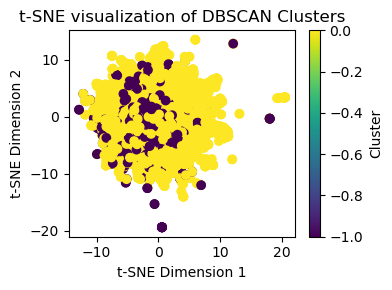

In [2752]:
from sklearn.manifold import TSNE

# Reduce dimensions to 2D using t-SNE for visualization
X_2d = TSNE(n_components=2).fit_transform(X_reduced)

# Create a scatter plot
labels = predict
plt.figure(figsize=(4, 3)) 
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)

plt.colorbar(scatter, label='Cluster')
plt.title("t-SNE visualization of DBSCAN Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()  
plt.show()

In [2754]:
#test whether they enhance LinearSVC performance by excluding them

In [2756]:
tfidf = TfidfVectorizer(max_df=0.45, min_df=1, ngram_range=(1, 2), sublinear_tf=True)


X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment']

# LinearSVC with 10-fold cross-validation
linear_svc = LinearSVC()

# 1. Cross-validation on the full dataset
cv_scores = cross_val_score(linear_svc, X_tfidf, y, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True), 
                            scoring='accuracy')

print('Avg cv accuracy:', (cv_scores.mean()))

Avg cv accuracy: 0.596625


In [2762]:
# Filter potential outliers
outliers = df.iloc[np.where(predict == -1)[0]]
filtered_df = df.iloc[np.where(predict != -1)[0]]

In [2774]:
X_filtered_tfidf = tfidf.transform(filtered_df['cleaned_text'])
y_filtered = filtered_df['sentiment']

# Cross-validation on the filtered dataset (excluding potential outliers)
cv_scores_filtered = cross_val_score(linear_svc, X_filtered_tfidf, y_filtered, 
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), 
                                     scoring='accuracy')

print('Avg cv accuracy after removing outliers:', (cv_scores_filtered.mean()))

Avg cv accuracy after removing outliers: 0.6041111050066321


This is a weird result since __excluding 23%__ of the initial dataset has __identical results__ with the entire dataset. 

## Feature Extraction
In this section, we will use various feature extraction methods to create a Bag of Words (BOW) or, more effectively, a document-term matrix using **TF-IDF** and **CountVectorizer**. These approaches will create a document matrix with columns representing the unique words in our dataset, where each data point is considered a vector. 

The models we will evaluate using these slightly different methods are:

- **LinearSVC (Support Vector Classificationt o with linear kernelf SVM that aims to separate the data points of each class in the feature space by finding a hyperplane that maximizes the margin between classes.
  
- **MultinomialNB (Naive Bayes)**: A probabilistic classifier that calculates the likelihood of each word belonging to a particular class, assuming feature independence (conditional on the class).

- **RandomForestClassifier**: An ensemble method based on decision trees. It uses a collection of decision trees to make predictions, where each tree splits the data based on the features that help in reducing the entropy (uncertainty) for classifying data points.

- **Logistic Regression**: A linear model that predicts the probability of a data point belonging to a particular class by applying a logistic function to a linear combination of the features. Despite being used for classification, it doesn’t explicitly separate classes in the feature space like SVM, but rather estimates class probabilities. It's often used for binary classification but can be extended to multiclass problems through methods like **one-vs-rest (OvR)**.

- **Voting Classifier**: An ensemble method that combines multiple basForest, etc.) and makes predictions based on the majority vote from all the individual models.

### Steps:

1. **Evaluate for each data mining algorithm**: We will test the performance of **TF-IDF** and **CountVectorizer** to see which method works best for each classifier.

2. **Parameter Tuning**: Once we identify the best vectorization/document matrix conversion method for each algorithm, we will slightly tune the parameters for optimal performance.


In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [139]:
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(df['cleaned_text'])

# Split into training and testing sets for CounterVectorizer
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(
    X_counts, 
    df['sentiment'], 
    test_size=0.1, 
    random_state=42, 
    stratify=df['sentiment']
)

print("Shape of CountVectorized data:", X_counts.shape)

Shape of CountVectorized data: (8000, 17608)


In [141]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Split into training and testing sets for tfi-idf
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, 
    df['sentiment'], 
    test_size=0.1, 
    random_state=42, 
    stratify=df['sentiment']
)

print("Shape of TfidfVectorizer data:", X_tfidf.shape)

Shape of TfidfVectorizer data: (8000, 17608)


In [147]:
vectorizers = {
    "CountVectorizer": (X_cv_train, X_cv_test, y_cv_train, y_cv_test),
    "TfidfVectorizer": (X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
}

# Models
models = {
    "LinearSVC": LinearSVC(),
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(),
    "LogisticReg": LogisticRegression()
}

results = []
for vectorizer_name, (X_train, X_test, y_train, y_test) in vectorizers.items():
    for model_name, model in models.items():
        # CV
        cv_scores = cross_val_score(model, 
                                    X_train, 
                                    y_train, 
                                    cv=StratifiedKFold(n_splits=10), 
                                    scoring='accuracy')
        avg_cv_score = cv_scores.mean()

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)

        # store the results
        results.append({
            "Vectorizer": vectorizer_name,
            "Model": model_name,
            "Avg_CV_Accuracy": avg_cv_score,
            "Test_Accuracy": test_accuracy
        })
        

In [148]:
# Convert results to df
results_df = pd.DataFrame(results)
# Reorder and sort the columns for the report 
results_df = results_df[['Model', 'Vectorizer', 'Avg_CV_Accuracy', 'Test_Accuracy']]
results_df = results_df.sort_values(by='Model')
results_df

,Model,Vectorizer,Avg_CV_Accuracy,Test_Accuracy
0,LinearSVC,CountVectorizer,0.536528,0.55000
4,LinearSVC,TfidfVectorizer,0.566667,0.60375
3,LogisticReg,CountVectorizer,0.560972,0.58500
7,LogisticReg,TfidfVectorizer,0.579167,0.61000
1,MultinomialNB,CountVectorizer,0.574722,0.56500
5,MultinomialNB,TfidfVectorizer,0.519167,0.55500
2,RandomForest,CountVectorizer,0.555417,0.57000
6,RandomForest,TfidfVectorizer,0.540556,0.56375


In [ ]:
#fix the df for the report...

In [199]:
modified_df = results_df.copy()
for model in results_df['Model'].unique():
    # Get the rows corresponding to the current model
    model_rows = modified_df[modified_df['Model'] == model]
    # Set the second occurrence of 'Model' to empty (i.e., leave it blank)
    if len(model_rows) > 1:
        second_occurrence_index = model_rows.index[1]  # The second row for this model
        modified_df.loc[second_occurrence_index, 'Model'] = ''


# Round the 'Avg_CV_Accuracy' and 'Test_Accuracy' columns to 3 decimal places
modified_df['Avg_CV_Accuracy'] = modified_df['Avg_CV_Accuracy'].round(2)
modified_df['Test_Accuracy'] = modified_df['Test_Accuracy'].round(2)
modified_df = modified_df.rename(columns={
    'Model': 'model',
    'Vectorizer': 'vectorizer',
    'Avg_CV_Accuracy': 'avg_cv_acc',
    'Test_Accuracy': 'test_acc'
})
modified_df

,model,vectorizer,avg_cv_acc,test_acc
0,LinearSVC,CountVectorizer,0.54,0.55
4,,TfidfVectorizer,0.57,0.60
3,LogisticReg,CountVectorizer,0.56,0.58
7,,TfidfVectorizer,0.58,0.61
1,MultinomialNB,CountVectorizer,0.57,0.56
5,,TfidfVectorizer,0.52,0.56
2,RandomForest,CountVectorizer,0.56,0.57
6,,TfidfVectorizer,0.54,0.56


In [209]:
X = df['cleaned_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Create pipelines for each model with their best vectorizer method
linear_svc_pipeline = make_pipeline(TfidfVectorizer(), LinearSVC())
multinomial_nb_pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
random_forest_pipeline = make_pipeline(CountVectorizer(), RandomForestClassifier())
logistic_reg_pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())

# Create the VotingClassifier with these individual models
voting_clf = VotingClassifier(estimators=[
    ('linear_svc', linear_svc_pipeline),
    ('multinomial_nb', multinomial_nb_pipeline),
    ('random_forest', random_forest_pipeline),
    ('logistic_reg', logistic_reg_pipeline)
], voting='hard')

# Evaluate the Voting clf with CV=10
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=StratifiedKFold(n_splits=10))

In [215]:
print('Avg CV Score:', round(np.mean(cv_scores),2)) 

Avg CV Score: 0.59


In [217]:
# Train
voting_clf.fit(X_train, y_train)
test_accuracy = voting_clf.score(X_test, y_test)
print('Test Accuracy:', round(test_accuracy,2))

Test Accuracy: 0.61


In [235]:
new_row = {
    "model": "Voting",
    "vectorizer": " ",
    "avg_cv_acc": round(np.mean(cv_scores),2),
    "test_acc": round(test_accuracy,2)
}
new_row_df = pd.DataFrame([new_row])  
modified_df = pd.concat([modified_df, new_row_df], ignore_index=True)

In [237]:
modified_df

,model,vectorizer,avg_cv_acc,test_acc
0,LinearSVC,CountVectorizer,0.54,0.55
1,,TfidfVectorizer,0.57,0.60
2,LogisticReg,CountVectorizer,0.56,0.58
3,,TfidfVectorizer,0.58,0.61
4,MultinomialNB,CountVectorizer,0.57,0.56
5,,TfidfVectorizer,0.52,0.56
6,RandomForest,CountVectorizer,0.56,0.57
7,,TfidfVectorizer,0.54,0.56
8,Voting,,0.59,0.61


#### Parameter Tuning for Feature Extraction Methods

In this section, we will determine the best parameters for our different data mining algorithms by using a few reasonable parameters in our GridSearch, aiming to avoid overfitting. These parameters will bring several benefits:

- **min_df**: This excludes words that appear in fewer than `min_df` documents. By setting an appropriate value, we can tackle issues such as __typos__ or irrelevant words.
- **ngram_range**: This defines the sequence of words to consider. For example, using __bigrams__ (two consecutive words) can improve the classifier's ability to understand context, thus enhancing model performance.

In [239]:
X = df['cleaned_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

#### LinearSVC - TF-IDF
I will also validate a step that we saw on 1st semester's course Data Programming.

In [244]:
# Custom Transformer for conditional Power Normalization
class ConditionalPowerNormalization(BaseEstimator, TransformerMixin):
    def __init__(self, transform_power_norm=True):
        self.transform_power_norm = transform_power_norm

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.transform_power_norm:
            X.data **= 0.5  # Apply square root transformation 
            # Normalize the sparse matrix
            normalize(X, copy=False)
        return X

In [257]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('power_norm', ConditionalPowerNormalization(transform_power_norm=True)),  
    ('svm_clf', LinearSVC())
])

param_grid = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__max_df': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], 
    'tfidf__max_features': [16500, 17000, 17500, None],   
    'tfidf__min_df': [1, 2, 3],  
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
    # Test different normalization strategies
    'tfidf__norm': ['l1', 'l2', None],  
    'power_norm__transform_power_norm': [True, False],  
}


grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=10))
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('power_norm',
                                        ConditionalPowerNormalization()),
                                       ('svm_clf', LinearSVC())]),
             param_grid={'power_norm__transform_power_norm': [True, False],
                         'tfidf__max_df': [0.3, 0.35, 0.4, 0.45, 0.5],
                         'tfidf__max_features': [10000, 12500, 15000, None],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__sublinear_tf': [True, False]},
             scoring='accuracy')

In [258]:
cv_results = grid_search.cv_results_
average_cv_score = np.mean(cv_results['mean_test_score'])

# Get the best model from grid search
best_model = grid_search.best_estimator_
# predict on test
y_pred = best_model.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Best cv score:", round(grid_search.best_score_,2))
print("Avg cv score:", round(average_cv_score,2))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'power_norm__transform_power_norm': True, 'tfidf__max_df': 0.3, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': False}
Best cv score: 0.6
Avg cv score: 0.56
Test Accuracy: 0.6175


In [261]:
results = [{
    "model": "LinearSVC",
    "vectorizer": "TfidfVectorizer",
    "best cv accuracy": round(grid_search.best_score_, 2),
    "test accuracy": round(accuracy_score(y_test, y_pred), 2),
}]

#### MultinomialNB - CountVectorizer

In [ ]:
# no need for normlization 

In [285]:
pipeline = Pipeline([
    ('count_vec', CountVectorizer()),
    ('multinomial_nb', MultinomialNB())
])

param_grid = {
    'count_vec__max_df': [0.25, 0.3, 0,35, 0.4, 0.45, 0.5],
    'count_vec__min_df': [1, 2, 3, 4],
    'count_vec__ngram_range': [(1, 1), (1, 2)],
    'count_vec__max_features': [16500, 17000, 17500, None]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=10))
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('count_vec', CountVectorizer()),
                                       ('multinomial_nb', MultinomialNB())]),
             param_grid={'count_vec__max_df': [0.25, 0.3, 0, 35, 0.4, 0.45,
                                               0.5],
                         'count_vec__max_features': [16500, 17000, 17500, None],
                         'count_vec__min_df': [1, 2, 3, 4],
                         'count_vec__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [291]:
cv_results = grid_search.cv_results_
average_cv_score = np.nanmean(cv_results['mean_test_score'])
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

results.append({
    "model": "MultinomialNB",
    "vectorizer": "CountVectorizer",  
    "best cv accuracy": round(grid_search.best_score_, 2),
    "test accuracy": round(accuracy_score(y_test, y_pred), 2),
})

print("Best parameters:", grid_search.best_params_)
print("Best cv score:", round(grid_search.best_score_,2))
print("Avg cv score:", round(average_cv_score,2))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred),2))

Best parameters: {'count_vec__max_df': 0.25, 'count_vec__max_features': None, 'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 2)}
Best cv score: 0.59
Avg cv score: 0.57
Test Accuracy: 0.57


#### Random Forest - CountVectorizer

In [343]:
pipeline = Pipeline([
    ('count_vec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

param_grid = {
    'count_vec__max_df': [0.4, 0.45, 0.5],
    'count_vec__min_df': [1, 2, 3],
    'count_vec__ngram_range': [(1, 1), (1, 2)],
    'count_vec__max_features': [17500, None]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=8))
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('count_vec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'count_vec__max_df': [0.4, 0.45, 0.5],
                         'count_vec__max_features': [17500, None],
                         'count_vec__min_df': [1, 2, 3],
                         'count_vec__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [347]:
cv_results = grid_search.cv_results_
average_cv_score = np.mean(cv_results['mean_test_score'])
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Best cv score:", round(grid_search.best_score_,2))
print("Avg cv score:", round(average_cv_score,2))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred),2))

Best parameters: {'count_vec__max_df': 0.5, 'count_vec__max_features': 17500, 'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 2)}
Best cv score: 0.56
Avg cv score: 0.56
Test Accuracy: 0.57


In [351]:
results.append({
    "model": "RandomForest",
    "vectorizer": "CountVectorizer",  
    "best cv accuracy": round(grid_search.best_score_, 2),
    "test accuracy": round(accuracy_score(y_test, y_pred), 2),
})

In [353]:
results

[{'model': 'LinearSVC',
  'vectorizer': 'TfidfVectorizer',
  'best cv accuracy': 0.6,
  'test accuracy': 0.62},
 {'model': 'MultinomialNB',
  'vectorizer': 'CountVectorizer',
  'best cv accuracy': 0.59,
  'test accuracy': 0.57},
 {'model': 'RandomForest',
  'vectorizer': 'CountVectorizer',
  'best cv accuracy': 0.56,
  'test accuracy': 0.57}]

#### Logistic Regression - TF-IDF

In [368]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('power_norm', ConditionalPowerNormalization(transform_power_norm=True)),  
    ('lr_clf', LogisticRegression())
])

param_grid = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__max_df': [0.2, 0.25, 0.45, 0.5], 
    'tfidf__min_df': [1, 2, 3],  
    'tfidf__ngram_range': [(1, 2)], 
    # Test different normalization strategies
    'tfidf__norm': ['l1', 'l2', None],  
    'power_norm__transform_power_norm': [True, False],  
}


grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=10))
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('power_norm',
                                        ConditionalPowerNormalization()),
                                       ('lr_clf', LogisticRegression())]),
             param_grid={'power_norm__transform_power_norm': [True, False],
                         'tfidf__max_df': [0.2, 0.25, 0.45, 0.5],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 2)],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__sublinear_tf': [True, False]},
             scoring='accuracy')

In [371]:
cv_results = grid_search.cv_results_
average_cv_score = np.mean(cv_results['mean_test_score'])
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

results.append({
    "model": "LogisticReg",
    "vectorizer": "TfidfVectorizer",  
    "best cv accuracy": round(grid_search.best_score_, 2),
    "test accuracy": round(accuracy_score(y_test, y_pred), 2),
})

print("Best parameters:", grid_search.best_params_)
print("Best cv score:", round(grid_search.best_score_,2))
print("Avg cv score:", round(average_cv_score,2))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred),2))

Best parameters: {'power_norm__transform_power_norm': False, 'tfidf__max_df': 0.25, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}
Best cv score: 0.6
Avg cv score: 0.57
Test Accuracy: 0.61


#### Voting with best params of TfidfVectorizer / CounterVectorizer for each model.

In [ ]:
# Create pipelines with best parameters of tfi-df/countervec for each model
linear_svc_pipeline = make_pipeline(
    TfidfVectorizer(max_df=0.3, max_features=None, min_df=1, ngram_range=(1, 2), norm='l1', sublinear_tf=False), 
    ConditionalPowerNormalization(transform_power_norm=True),
    LinearSVC()
)

multinomial_nb_pipeline = make_pipeline(
    CountVectorizer(max_df=0.25, min_df=2, ngram_range=(1, 2)),  
    MultinomialNB()
)

#rf_pipeline = make_pipeline(
#    CountVectorizer(max_df=0.45, min_df=3, ngram_range=(1, 2)),  
#    RandomForestClassifier()
#)

logistic_reg_pipeline = make_pipeline(
    TfidfVectorizer(max_df=0.45, min_df=2, ngram_range=(1, 2), sublinear_tf=True),  
    LogisticRegression()
)

# Voting classifier 
voting_clf = VotingClassifier(estimators=[
    ('linear_svc', linear_svc_pipeline),
    ('multinomial_nb', multinomial_nb_pipeline),
#    ('rf', rf_pipeline),
    ('logistic_reg', logistic_reg_pipeline)
], voting='hard')

# CV
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=StratifiedKFold(n_splits=10))

In [895]:
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

results.append({
    "model": "Voting",
    "vectorizer": " ",  
    "best cv accuracy": round(np.mean(cv_scores), 2), 
    "test accuracy": round(test_accuracy, 2)
})

print('Avg CV Score:', round(np.mean(cv_scores),2))
print('Test Accuracy:', round(test_accuracy,2))

Avg CV Score: 0.60
Test Accuracy: 0.63


In [901]:
results2 = pd.DataFrame(results).sort_values(by='model')
results2 = results2.rename(columns={'best cv accuracy': 'cv accuracy'})
results2

,model,vectorizer,cv accuracy,test accuracy
0,LinearSVC,TfidfVectorizer,0.60,0.62
3,LogisticReg,TfidfVectorizer,0.60,0.62
1,MultinomialNB,CountVectorizer,0.59,0.59
2,RandomForest,CountVectorizer,0.57,0.56
4,Voting,,0.60,0.63


#### Takeaways
- LinearSVC and Logistic Regression have almost identical results, both performing better with TF-IDF.
- MultinomialNB has slightly worse results.
- Random Forest did not improve at all even after tuning CountVectorizer.
- Voting slightly improves the results, with RandomForest excluded from Voting.

## Hyperparameter Tuning of the Selected Data Mining Algorithms

In this section, we will conduct experiments to optimize key parameters of each data mining algorithm. Our goal will be to __fine-tune__ the models __without overfitting__, ensuring the best possible performance on unseen data. Additionally, we will evaluate the models' performance using various metrics, including __classification reports__, to understand their strengths and weaknesses. Metrics like precision, recall, and F1-score for each class will allow us to gain deeper insights into the trade-offs between different models, helping us select the most suitable one for our task.

In [475]:
X = df['cleaned_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [459]:
df.sentiment.value_counts(normalize=True)

sentiment
positive    0.382875
neutral     0.349375
negative    0.267750
Name: proportion, dtype: float64

In [461]:
class_counts = df.sentiment.value_counts(normalize=True)
class_weights = {label: 1 / freq for label, freq in class_counts.items()}

# Normalize weights so they sum to 1)
total_weight = sum(class_weights.values())
class_weights_normalized = {label: weight / total_weight for label, weight in class_weights.items()}

print("Class Weights:", class_weights)
print("Normalized Class Weights:", class_weights_normalized)

Class Weights: {'positive': 2.611818478615736, 'neutral': 2.862254025044723, 'negative': 3.734827264239029}
Normalized Class Weights: {'positive': 0.2836189495427075, 'neutral': 0.31081389711961116, 'negative': 0.40556715333768123}


#### LinearSVC

In [940]:
# C values to test
C_values = [ 1, 5, 10, 20, 30, 40, 50, 60, 70, 80]

cv_accuracies = []
test_accuracies = []
for C in C_values:
    # Set the value of C for LinearSVC
    linear_svc_pipeline.set_params(linearsvc__C=C)
    
    # cross-validation
    cv_scores = cross_val_score(linear_svc_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    # Train / Predict
    linear_svc_pipeline.fit(X_train, y_train)
    y_pred = linear_svc_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    cv_accuracies.append(cv_scores.mean())  # avge of the CV scores
    test_accuracies.append(test_accuracy)   # test accuracy

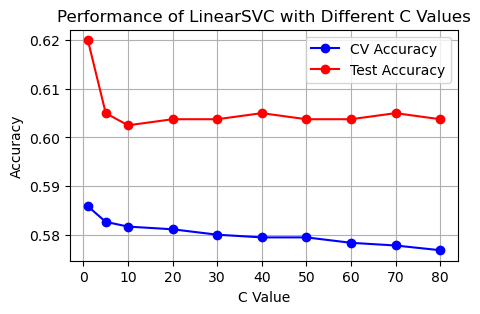

In [941]:
# Plotting the results
plt.figure(figsize=(5, 3))

plt.plot(C_values, cv_accuracies, label="CV Accuracy", marker='o', linestyle='-', color='blue')
plt.plot(C_values, test_accuracies, label="Test Accuracy", marker='o', linestyle='-', color='red')

plt.title('Performance of LinearSVC with Different C Values')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [1100]:
param_grid = {
    'linearsvc__C': [0.5, 0.75, 1],
    'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__class_weight': [class_weights_normalized, 'balanced', None]  # test weights
}

grid_search = GridSearchCV(
    estimator=linear_svc_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10),
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'linearsvc__C': 0.5, 'linearsvc__class_weight': {'positive': 0.2836189495427075, 'neutral': 0.31081389711961116, 'negative': 0.40556715333768123}, 'linearsvc__loss': 'squared_hinge'}
Best CV Score: 0.5986111111111111


In [1080]:
# Evaluate on test set
y_pred = grid_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.62125


In [1083]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.58      0.60      0.59       214
     neutral       0.61      0.53      0.56       280
    positive       0.66      0.72      0.69       306

    accuracy                           0.62       800
   macro avg       0.62      0.62      0.61       800
weighted avg       0.62      0.62      0.62       800



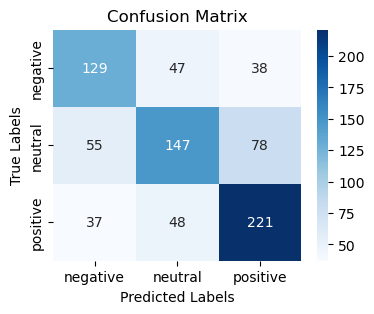

In [1085]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=grid_search.best_estimator_.classes_, yticklabels=grid_search.best_estimator_.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

\
Retrieve the Classification Report and Confusion Matrix without weights on the target variable.

In [1088]:
param_grid_no_weights = {
    'linearsvc__C': [0.5, 0.75, 1],
    'linearsvc__loss': ['hinge', 'squared_hinge']
}

grid_search_no_weights = GridSearchCV(
    estimator=linear_svc_pipeline,
    param_grid=param_grid_no_weights,
    cv=StratifiedKFold(n_splits=10),
    scoring='accuracy',
    n_jobs=-1
)


grid_search_no_weights.fit(X_train, y_train)

print("Best Parameters No Weights:", grid_search_no_weights.best_params_)
print("Best CV Score No Weights:", grid_search_no_weights.best_score_)

y_pred_no_weights = grid_search_no_weights.best_estimator_.predict(X_test)

Best Parameters No Weights: {'linearsvc__C': 0.75, 'linearsvc__loss': 'squared_hinge'}
Best CV Score No Weights: 0.5962500000000001


In [1098]:
# Evaluate on test set
y_pred = grid_search_no_weights.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_no_weights)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.625


In [1090]:
report_no_weights = classification_report(y_test, y_pred_no_weights)
print("Classification Report (No Weights):\n", report_no_weights)

Classification Report (No Weights):
               precision    recall  f1-score   support

    negative       0.61      0.56      0.59       214
     neutral       0.60      0.55      0.57       280
    positive       0.65      0.74      0.69       306

    accuracy                           0.62       800
   macro avg       0.62      0.62      0.62       800
weighted avg       0.62      0.62      0.62       800



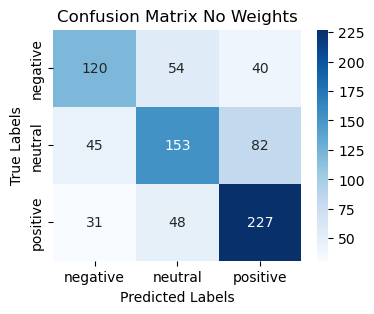

In [1129]:
cm = confusion_matrix(y_test, y_pred_no_weights)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=grid_search_no_weights.best_estimator_.classes_, yticklabels=grid_search_no_weights.best_estimator_.classes_)
plt.title('Confusion Matrix No Weights')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

\
Repeating the GridSeatch using a different random_state as the test accuracy to remove bias, \
as __test accuracy__ is always better than the accuracy with best params from GS.

__Note:__ I m doing this in order to understand whether __LinearSVC generalizes__ better on unseen data or not.

In [1348]:
X = df['cleaned_text2']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

In [1350]:
param_grid = {
    'linearsvc__C': [0.5, 0.75, 1],
    'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__class_weight': [class_weights_normalized, 'balanced'] 
}

grid_search = GridSearchCV(
    estimator=linear_svc_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10),
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'linearsvc__C': 0.5, 'linearsvc__class_weight': {'positive': 0.2836189495427075, 'neutral': 0.31081389711961116, 'negative': 0.40556715333768123}, 'linearsvc__loss': 'squared_hinge'}
Best CV Score: 0.5976388888888888


In [1351]:
# Evaluate on test set# Evaluate on test set
y_pred = grid_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.6325


Having again higher test accuracy means that it really does generalize better. Now i will proceed \
by running only the initial GridSearch in order to not introduce any bias on the results of the \
other data mining algorithms.

In [1169]:
#Using the initial Train/Test
X = df['cleaned_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

#### MultinomialNB

understand how alpha parameter works before defining the GridSearch to define the best params in order to 'save' some time.

In [1191]:
alpha_values = [0.1, 1.0, 3, 6, 9, 12, 15]

cv_accuracies = []
test_accuracies = []

# Loop through each alpha value and evaluate the model
for alpha in alpha_values:
    # Set the value of alpha for MultinomialNB
    multinomial_nb_pipeline.set_params(multinomialnb__alpha=alpha)
    
    # Cross-validation scores
    cv_scores = cross_val_score(multinomial_nb_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    
    # Train the model and predict
    multinomial_nb_pipeline.fit(X_train, y_train)
    y_pred = multinomial_nb_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Store the mean of CV accuracies and test accuracy
    cv_accuracies.append(cv_scores.mean())  # Average of the CV scores
    test_accuracies.append(test_accuracy)   # Test accuracy

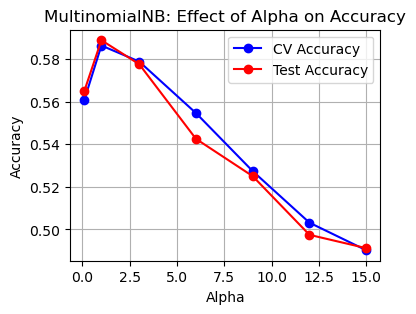

In [1225]:
plt.figure(figsize=(4, 3))
plt.plot(alpha_values, cv_accuracies, label="CV Accuracy", marker='o', linestyle='-', color='blue')
plt.plot(alpha_values, test_accuracies, label="Test Accuracy", marker='o', linestyle='-', color='red')
plt.title('MultinomialNB: Effect of Alpha on Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [1172]:
param_grid = {
    'multinomialnb__alpha': [0.5, 0.75, 1.0],         
    'multinomialnb__fit_prior': [True, False]                
}

grid_search_multinomial = GridSearchCV(
    estimator=multinomial_nb_pipeline, 
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10),        
    scoring='accuracy',                   
    n_jobs=-1,                            
)

grid_search_multinomial.fit(X_train, y_train)

print("Best Parameters for MultinomialNB:", grid_search_multinomial.best_params_)
print("Best CV Score:", round(grid_search_multinomial.best_score_,2))

Best Parameters for MultinomialNB: {'multinomialnb__alpha': 1.0, 'multinomialnb__fit_prior': True}
Best CV Score: 0.59


In [1173]:
y_pred = grid_search_multinomial.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(test_accuracy,2))

Test Accuracy: 0.59


In [1176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.56      0.53      0.54       214
     neutral       0.58      0.53      0.55       280
    positive       0.62      0.68      0.65       306

    accuracy                           0.59       800
   macro avg       0.58      0.58      0.58       800
weighted avg       0.59      0.59      0.59       800



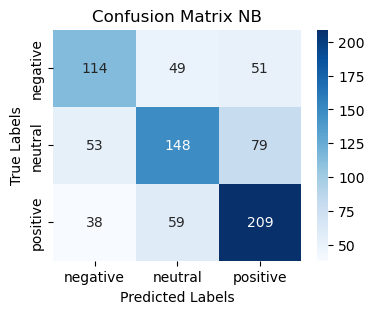

In [1182]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=grid_search_multinomial.best_estimator_.classes_, yticklabels=grid_search_multinomial.best_estimator_.classes_)
plt.title('Confusion Matrix NB')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Logistic Reggression


In [1210]:
param_grid_logreg = {
    'logisticregression__C': [0.1, 0.5, 1.0], 
    'logisticregression__penalty': ['l1', 'l2'],         
    'logisticregression__solver': ['liblinear', 'newton-cg', 'saga', 'lbfgs'],   # Solvers that support multinomial loss
    'logisticregression__multi_class': ['ovr', 'multinomial'],
    'logisticregression__class_weight': [class_weights_normalized, 'balanced', None]  # Class weights for handling imbalance
}

grid_search_logreg = GridSearchCV(
    estimator=logistic_reg_pipeline,
    param_grid=param_grid_logreg,
    cv=StratifiedKFold(n_splits=10),      
    scoring='accuracy',                   
    n_jobs=-1,                          
)

grid_search_logreg.fit(X_train, y_train)

print("Best Parameters for Logistic Regression:", grid_search_logreg.best_params_)
print("Best CV Score:", round(grid_search_logreg.best_score_, 2))

Best Parameters for Logistic Regression: {'logisticregression__C': 1.0, 'logisticregression__class_weight': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Best CV Score: 0.6


In [1217]:
# Evaluate on test
y_pred_logreg = grid_search_logreg.best_estimator_.predict(X_test)
test_accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Test Accuracy for Logistic Regression:", round(test_accuracy_logreg, 2))

Test Accuracy for Logistic Regression: 0.62


In [1219]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

    negative       0.64      0.52      0.57       214
     neutral       0.58      0.54      0.56       280
    positive       0.63      0.76      0.69       306

    accuracy                           0.62       800
   macro avg       0.62      0.61      0.61       800
weighted avg       0.62      0.62      0.61       800



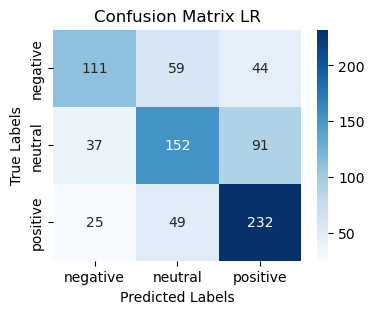

In [1221]:
cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=grid_search_logreg.best_estimator_.classes_, yticklabels=grid_search_logreg.best_estimator_.classes_)
plt.title('Confusion Matrix LR')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### RF

In [1263]:
# Create the pipeline with CountVectorizer and RandomForestClassifier
rf_pipeline = make_pipeline(
    CountVectorizer(max_df=0.45, min_df=3, ngram_range=(1, 2)),  # these were the best parameters from CountVectorizer
    RandomForestClassifier(random_state=42)
)

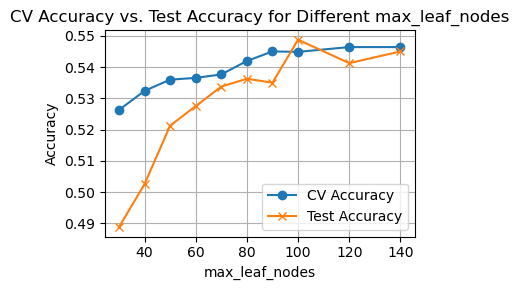

In [1271]:
max_leaf_nodes_list = [30, 40, 50, 60, 70, 80, 90, 100, 120, 140]
cv_accuracies = []
test_accuracies = []

# Loop through different values for max_leaf_nodes
for max_leaf_nodes in max_leaf_nodes_list:
    # Set the current max_leaf_nodes parameter
    rf_pipeline.set_params(randomforestclassifier__max_leaf_nodes=max_leaf_nodes)
    
    # CV
    cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring='accuracy')
    cv_accuracies.append(cv_scores.mean())
    
    # Train the model and test it on the test data
    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)  

# Plotting the results
plt.figure(figsize=(4, 3))
plt.plot(max_leaf_nodes_list, cv_accuracies, marker='o', label='CV Accuracy')
plt.plot(max_leaf_nodes_list, test_accuracies, marker='x', label='Test Accuracy')
plt.title("CV Accuracy vs. Test Accuracy for Different max_leaf_nodes")
plt.xlabel("max_leaf_nodes")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

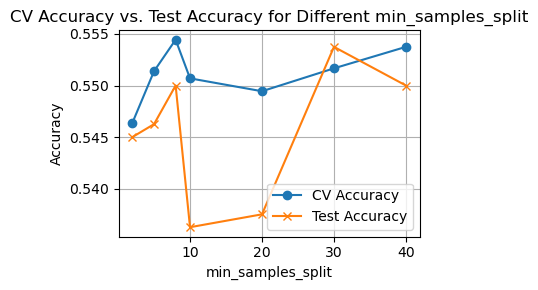

In [1281]:
min_samples_split_list = [2, 5, 8 , 10, 20, 30, 40]
cv_accuracies = []
test_accuracies = []

# Loop through different values for min_samples_split
for min_samples_split in min_samples_split_list:
    # Set the current min_samples_split parameter
    rf_pipeline.set_params(randomforestclassifier__min_samples_split=min_samples_split)
    
    # CV
    cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring='accuracy')
    cv_accuracies.append(cv_scores.mean())
    
    # Train the model and test it on the test data
    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)  

# Plotting the results
plt.figure(figsize=(4, 3))
plt.plot(min_samples_split_list, cv_accuracies, marker='o', label='CV Accuracy')
plt.plot(min_samples_split_list, test_accuracies, marker='x', label='Test Accuracy')
plt.title("CV Accuracy vs. Test Accuracy for Different min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.show()

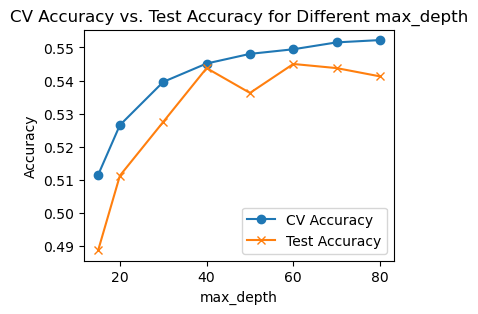

In [1290]:
max_depth_list = [15, 20, 30, 40, 50, 60, 70, 80]
cv_accuracies = []
test_accuracies = []

# Loop through different values for max_depth
for max_depth in max_depth_list:
    # Set the current max_depth parameter
    rf_pipeline.set_params(randomforestclassifier__max_depth=max_depth)
    
    # CV
    cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring='accuracy')
    cv_accuracies.append(cv_scores.mean())
    
    # Train the model and test it on the test data
    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)  

# Plotting the results
plt.figure(figsize=(4, 3))
plt.plot(max_depth_list, cv_accuracies, marker='o', label='CV Accuracy')
plt.plot(max_depth_list, test_accuracies, marker='x', label='Test Accuracy')
plt.title("CV Accuracy vs. Test Accuracy for Different max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Extract Feature Importance

Since the Random Forest classifier performed slightly worse compared to other classifiers, I ran the preprocessing steps again using __lemmatizer__ instead of the Porter stemmer to extract the **Feature Importance**, the most influential words/features.

In [ ]:
# this took 3 hr care!!!

In [3126]:
# Define the pipeline
rf_pipeline = make_pipeline(
    CountVectorizer(max_df=0.45, min_df=3, ngram_range=(1, 2)),
    RandomForestClassifier(random_state=42)
)

param_grid = {
    "randomforestclassifier__n_estimators": [100, 150],
    "randomforestclassifier__max_depth": [None, 60, 100],  
    "randomforestclassifier__min_samples_split": [5, 8, 30],
    "randomforestclassifier__max_features": ['sqrt', 'log2', None],  
    "randomforestclassifier__criterion": ["gini", "entropy"]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),  
    scoring="accuracy",
    n_jobs=-1,  
    verbose=1   
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(('Best parameters:', grid_search.best_params_))
print('Best CV Accuracy:', round(grid_search.best_score_),2))
print('Test Set Accuracy:', round(accuracy_score(y_test, y_pred),2))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 150}
Best CV Accuracy: 0.57
Test Set Accuracy: 0.56


In [3133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.67      0.34      0.45       214
     neutral       0.52      0.54      0.53       280
    positive       0.55      0.72      0.62       306

    accuracy                           0.56       800
   macro avg       0.58      0.53      0.53       800
weighted avg       0.57      0.56      0.54       800



In [ ]:
#terrible results , introduce weight on classes!!!!!!!!!!

In [3147]:
rf_pipeline.set_params(
    randomforestclassifier__min_samples_split=8,
    randomforestclassifier__max_features='log2',
    randomforestclassifier__criterion='gini'
)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.45, min_df=3, ngram_range=(1, 2))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features='log2',
                                        min_samples_split=8,
                                        random_state=42))])

In [3171]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

# Define the stopwords, excluding 'not'
nltk_stopwords = set(stopwords.words('english'))
sklearn_stopwords = ENGLISH_STOP_WORDS
custom_stopwords = (nltk_stopwords | sklearn_stopwords) - {"not"}

# Function to remove stopwords
def remove_stopwords(text, stopwords):
    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return " ".join(filtered_words)

# Apply the function to cleaned_text
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_stopwords(x, custom_stopwords))

# Split the data
X = df['cleaned_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [3173]:
param_grid = {
    "randomforestclassifier__n_estimators": [290,300,310],  # i tested this and max_depth 
    "randomforestclassifier__max_depth": [None, 350],       # 10 + times with different numbers in order to save some time
    "randomforestclassifier__min_samples_leaf": [1, 2, 3],  
    "randomforestclassifier__class_weight": [class_weights_normalized, 'balanced']      
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),  
    scoring="accuracy",
    n_jobs=-1, 
    verbose=1   
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(('Best parameters:', grid_search.best_params_))
print('Best CV Accuracy:', round(grid_search.best_score_,2))
print('Test Set Accuracy:', round(accuracy_score(y_test, y_pred),2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
('Best parameters:', {'randomforestclassifier__class_weight': {'positive': 0.2836189495427075, 'neutral': 0.31081389711961116, 'negative': 0.40556715333768123}, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 310})
Best CV Accuracy: 0.58
Test Set Accuracy: 0.58


In [3186]:
rf_model = best_model.named_steps['randomforestclassifier']
tree_depths = [tree.tree_.max_depth for tree in rf_model.estimators_]

In [3188]:
np.max(tree_depths)

371

In [3190]:
np.min(tree_depths)

81

In [3175]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.55      0.60      0.58       214
     neutral       0.55      0.53      0.54       280
    positive       0.63      0.60      0.62       306

    accuracy                           0.58       800
   macro avg       0.58      0.58      0.58       800
weighted avg       0.58      0.58      0.58       800



In [3177]:
# Extract the RandomForestClassifier and CountVectorizer from the pipeline
vectorizer = best_model.named_steps['countvectorizer']
rf_model = best_model.named_steps['randomforestclassifier']

# Get feature names from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Get feature importances from the RandomForestClassifier
feature_importances = rf_model.feature_importances_

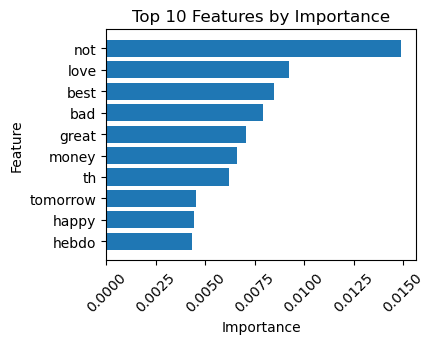

In [3181]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

top_10_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(4, 3))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.gca().invert_yaxis()  
plt.title('Top 10 Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45)
plt.show()

#### Note
Remember on EDA the word __th__ was top 5 on neutral, which denotes to __random dates__ e.g 19nth of July. 

In [3183]:
importance_df.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
4544,not,0.014920
3944,love,0.009246
539,best,0.008498
413,bad,0.007946
2813,great,0.007080
4286,money,0.006592
6815,th,0.006210
7048,tomorrow,0.004544
2947,happy,0.004428
3031,hebdo,0.004352


In [3198]:
importance_df.sort_values(by='Importance', ascending=False).tail(5)

,Feature,Importance
4466,nerd,0.0
4454,need work,0.0
4444,necessity,0.0
4439,near end,0.0
3908,look new,0.0


In [1478]:
ira_rows = df[df['cleaned_text'].str.contains(r'\bira\b', case=False, na=False)]
ira_rows.text.iloc[0]

"Cameron's comments may be overly rough on Labour MP's, but McDonnell called for Labour councillors to have kneecaps shot off by the IRA."

In [1480]:
ira_rows.text.iloc[1]

"When the IRA bombed the Baltic Exchange, The Good Friday Agreement began. Let's not waste time. Let's give ISIS a caliphate...on Pluto. Now."

In [1482]:
ira_rows.sentiment.value_counts(normalize=True)

sentiment
negative    0.505747
neutral     0.408046
positive    0.086207
Name: proportion, dtype: float64

In [ ]:
#before removing stop words !!!!!!!!!!!!!!!!!!!!!!!

In [3162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.58      0.52      0.55       214
     neutral       0.57      0.59      0.58       280
    positive       0.62      0.63      0.63       306

    accuracy                           0.59       800
   macro avg       0.59      0.58      0.58       800
weighted avg       0.59      0.59      0.59       800



In [3163]:
# Extract the RandomForestClassifier and CountVectorizer from the pipeline
vectorizer = best_model.named_steps['countvectorizer']
rf_model = best_model.named_steps['randomforestclassifier']

# Get feature names from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Get feature importances from the RandomForestClassifier
feature_importances = rf_model.feature_importances_

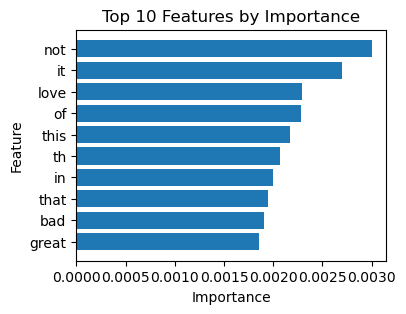

In [3164]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

top_10_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(4, 3))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.gca().invert_yaxis()  
plt.title('Top 10 Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Voting after tuning

In [1242]:
best_params_svc = grid_search.best_params_  
best_params_multinomial = grid_search_multinomial.best_params_ 
best_params_logreg = grid_search_logreg.best_params_ 

# Create pipelines with the best parameters for each model

linear_svc_pipeline = make_pipeline(
    TfidfVectorizer(max_df=0.45, min_df=1, ngram_range=(1, 2), sublinear_tf=True), 
    ConditionalPowerNormalization(transform_power_norm=True),
    LinearSVC(C=best_params_svc['linearsvc__C'], loss=best_params_svc['linearsvc__loss'])
)

multinomial_nb_pipeline = make_pipeline(
    CountVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2)),  
    MultinomialNB(alpha=best_params_multinomial['multinomialnb__alpha'], fit_prior=best_params_multinomial['multinomialnb__fit_prior'])
)

logistic_reg_pipeline = make_pipeline(
    TfidfVectorizer(max_df=0.45, min_df=2, ngram_range=(1, 2), sublinear_tf=True),
    LogisticRegression(C=best_params_logreg['logisticregression__C'],
                       penalty=best_params_logreg['logisticregression__penalty'],
                       solver=best_params_logreg['logisticregression__solver'],
                       multi_class=best_params_logreg['logisticregression__multi_class'],
                       class_weight=best_params_logreg['logisticregression__class_weight'])
)

voting_clf = VotingClassifier(estimators=[
    ('linear_svc', linear_svc_pipeline),
    ('multinomial_nb', multinomial_nb_pipeline),
    ('logistic_reg', logistic_reg_pipeline)
], voting='hard')  

cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=StratifiedKFold(n_splits=10))

In [1254]:
# Fit the VotingClassifier on the training data and evaluate on the test data
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Mean CV Accuracy:", round(cv_scores.mean(), 2))
print("Test Accuracy of Voting Classifier:", round(test_accuracy, 2))

Mean CV Accuracy: 0.6
Test Accuracy of Voting Classifier: 0.63


In [1245]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.63      0.54      0.58       214
     neutral       0.60      0.55      0.58       280
    positive       0.65      0.76      0.70       306

    accuracy                           0.63       800
   macro avg       0.62      0.62      0.62       800
weighted avg       0.63      0.63      0.62       800



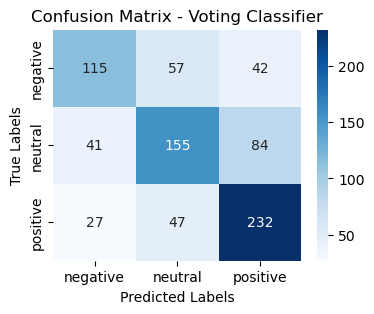

In [1260]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Nothing special after parameter tuning .........

### Test SVC to return Neutral for <60% negative posotive
I used LinearSVC because it is faster than SVC (he also had better performance) but since LinearSVC does not return propabilities,
I will use the SVC here with a 75-25 train-test split.

In [650]:
from sklearn.svm import SVC

# Define the dataset
X = df['cleaned_text']
y = df['sentiment']

# Split the data with 80-20 this time..
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6, stratify=y)

# pipeline with SVC and tf-idf
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.45, min_df=1, ngram_range=(1, 2), sublinear_tf=True)),
    ('svm_clf', SVC(C=0.5, kernel='linear', probability=True))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.45, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svm_clf', SVC(C=0.5, kernel='linear', probability=True))])

In [651]:
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.57      0.44      0.50       535
     neutral       0.54      0.49      0.51       699
    positive       0.59      0.73      0.65       766

    accuracy                           0.57      2000
   macro avg       0.57      0.56      0.56      2000
weighted avg       0.57      0.57      0.56      2000



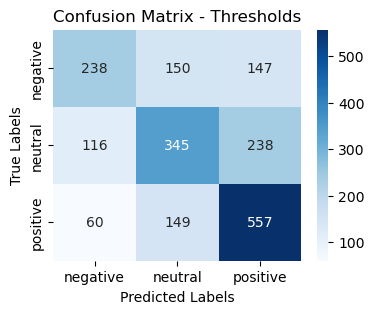

In [696]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title('Confusion Matrix - Thresholds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [626]:
# we overpredict positive

In [628]:
df.sentiment.value_counts(normalize=True)

sentiment
positive    0.382875
neutral     0.349375
negative    0.267750
Name: proportion, dtype: float64

In [700]:
# Transform the test data
X_test_tfidf = pipeline.named_steps['tfidf'].transform(X_test)

# Predict probabilities on the test data
svm_clf = pipeline.named_steps['svm_clf']
probabilities = svm_clf.predict_proba(X_test_tfidf)

# Get class labels
class_labels = svm_clf.classes_

In [706]:
# Modify prediction logic
threshold = 0.38 
predicted_labels = svm_clf.predict(X_test_tfidf)  # Initial predictions

# Adjust predictions based on confidence
for idx, predicted_label in enumerate(predicted_labels):
    # Get the probability of the predicted class
    predicted_prob = probabilities[idx][class_labels.tolist().index(predicted_label)]
    
    # Avoid overpredicting positive
    if predicted_prob < threshold:
        if predicted_label == 'positive':  
            neutral_prob = probabilities[idx][class_labels.tolist().index('neutral')]
            negative_prob = probabilities[idx][class_labels.tolist().index('negative')]
            if neutral_prob > negative_prob:
                predicted_labels[idx] = 'neutral'
            else:
                predicted_labels[idx] = 'negative'

# Evaluate the model
test_accuracy = accuracy_score(y_test, predicted_labels)
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

    negative       0.53      0.52      0.52       535
     neutral       0.53      0.50      0.51       699
    positive       0.63      0.66      0.64       766

    accuracy                           0.57      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.57      0.57      0.57      2000



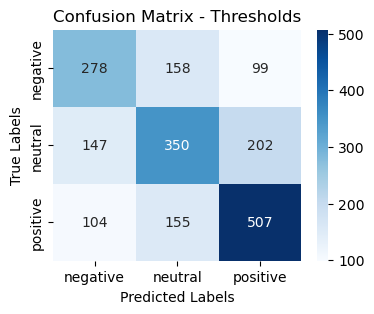

In [707]:
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title('Confusion Matrix - Thresholds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Test whether Decomposition enhances the performance of LinearSVC
Because LinearSVC used bigrams on the tf-idf GridSearch, the vocabulary is increased and the matrix became __sparser__.
Since the algorithm maps the data points to space and tries to seperate them, having sparse data points / vectors might have a negative impact when SVM tries to find an optimal hyperplane that separates the classes.

In [ ]:
from sklearn.decomposition import TruncatedSVD

tfidf = TfidfVectorizer(max_df=0.45, min_df=1, ngram_range=(1, 2), sublinear_tf=True)

# Transform the data using TF-IDF
X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment']

In [188]:
# Retrieve the number features from the TfidfVectorizer = new vocabulary after bigrams
len(tfidf.get_feature_names_out())

149554

In [ ]:
components_list = [200, 500, 1000, 1500, 2000, 5000]
results = []
for n_components in components_list:
    # Apply TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_tfidf)
    
    # cv=10 
    linear_svc = LinearSVC()
    cv_scores = cross_val_score(linear_svc, X_svd, y, 
                                cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), 
                                scoring='accuracy')
    
    # Calculate and store the average accuracy
    avg_accuracy = cv_scores.mean()
    results.append({'components': n_components, 'avg_accuracy': avg_accuracy})

In [198]:
results_df = pd.DataFrame(results)
results_df["avg_accuracy"] = results_df["avg_accuracy"].round(2)
results_df

,components,avg_accuracy
0,200,0.56
1,500,0.58
2,1000,0.59
3,1500,0.59
4,2000,0.58
5,5000,0.56


# RRN (LSTM)

In [68]:
def remove_short_words(text):
    words = text.split() 
    filtered_words = [word for word in words if len(word) >= 2]  
    return ' '.join(filtered_words)  

df['cleaned_text'] = df['cleaned_text'].apply(remove_short_words)

In [70]:
def preprocess_text_with_token_limit(text, token_limit=200, token_cut=100):

    tokens = word_tokenize(text)
    if len(tokens) > token_limit:
        tokens = tokens[:token_cut] + tokens[-token_cut:]
    
    return ' '.join(tokens)

df['cleaned_text'] = df['cleaned_text'].apply(preprocess_text_with_token_limit)

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from sklearn.preprocessing import LabelEncoder

# Text data and target sentiment labels
texts = df['cleaned_text']  
sentiments = df['sentiment'] 


max_features = 10000  # Vocabulary size
maxlen = 100  # Max sequence length

# Tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)  # Fit tokenizer on the entire dataset
x_data = tokenizer.texts_to_sequences(texts)

# Padding the sequences to the same length
x_data = pad_sequences(x_data, maxlen=maxlen)

# Label Encoding and One-Hot Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(sentiments)
y_one_hot = to_categorical(y_encoded, num_classes=3)  #(negative, neutral, positive)

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Parameters GIGA TEST them on the future when i have time !!!!
batch_size = 20
word_embedding_dim = 50
lstm_hidden_dim = 64  # LSTM hidden dimension size


# LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features, output_dim=word_embedding_dim, input_length=maxlen))
model_lstm.add(LSTM(units=lstm_hidden_dim, activation='tanh', return_sequences=False))
model_lstm.add(Dropout(0.7))
model_lstm.add(Dense(3, activation='softmax'))  

# Compile
optimizer = Adam(learning_rate=0.0003)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model_lstm.fit(
    x_data, y_one_hot,
    batch_size=batch_size,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],  # early stopping to save time:))
    shuffle=True  # Shuffle the data before splitting
)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.3695 - loss: 1.0883 - val_accuracy: 0.4125 - val_loss: 1.0648
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.4718 - loss: 1.0299 - val_accuracy: 0.5213 - val_loss: 0.9971
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6016 - loss: 0.8695 - val_accuracy: 0.5575 - val_loss: 0.9466
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7213 - loss: 0.6880 - val_accuracy: 0.5681 - val_loss: 0.9293
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7967 - loss: 0.5553 - val_accuracy: 0.5587 - val_loss: 1.0071
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8307 - loss: 0.4668 - val_accuracy: 0.5688 - val_loss: 1.1113


In [158]:
# OVERFIT all the time, nothings works.

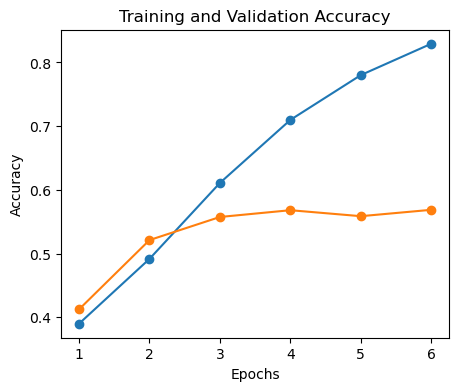

In [162]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(5, 4))

plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##### TEST WHEN I HAVE TIME
1. word embedding (represenation of each token to space) and LSTM dims with Grid Search + batch sizes to learn smoother the weights and prevent overfitting 
2. Regularization techniques L1, L2 + different dropouts
3. READ THIS for [LSTM Overfitting](https://fastercapital.com/topics/handling-overfitting-in-lstm-models.html#:~:text=Data%20augmentation%3A%20Increasing%20the%20size,data%2C%20or%20generating%20synthetic%20samples.)
4. Different vocabulary lengths (max features) and maxlen on the texts